In [1]:
!pip install matplotlib==3.5.0
import warnings

warnings.filterwarnings("ignore")

In [2]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

2023-04-17 05:16:12.306116: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 05:16:13.108036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df_pre = pd.read_csv('Sunspots.csv')
df_pre["time_idx"] = df_pre['Unnamed: 0'].apply(lambda x: x)
print(df_pre.head)
df = df_pre.iloc[:,2:]
df["const"] = 1

df.rename(columns = {'Monthly Mean Total Sunspot Number': 'sunspots'}, inplace = True)

print(df.head())

<bound method NDFrame.head of       Unnamed: 0        Date  Monthly Mean Total Sunspot Number  time_idx
0              0  1749-01-31                               96.7         0
1              1  1749-02-28                              104.3         1
2              2  1749-03-31                              116.7         2
3              3  1749-04-30                               92.8         3
4              4  1749-05-31                              141.7         4
...          ...         ...                                ...       ...
3260        3260  2020-09-30                                0.6      3260
3261        3261  2020-10-31                               14.4      3261
3262        3262  2020-11-30                               34.0      3262
3263        3263  2020-12-31                               21.8      3263
3264        3264  2021-01-31                               10.4      3264

[3265 rows x 4 columns]>
   sunspots  time_idx  const
0      96.7         0      

In [4]:
max_prediction_length = 50 
max_encoder_length = 500
test_cutoff = df["time_idx"].max() - 500
df_prim = df[lambda x: x.time_idx < test_cutoff]
training_cutoff = df_prim["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df_prim[lambda x: x.time_idx <= training_cutoff],
    time_idx = "time_idx",
    target = 'sunspots',
    group_ids = ["const"],
    min_encoder_length = max_encoder_length,
    max_encoder_length = max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["sunspots"],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)

validation = TimeSeriesDataSet.from_dataset(training, df_prim, predict=True, stop_randomization=True)
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size)

In [5]:
pl.seed_everything(43)

Global seed set to 43


43

In [6]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-7, patience=20, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.68,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.05,
    hidden_size=8,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=2,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 4.8k


In [7]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [8]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 24    
4  | static_variable_selection          | VariableSelectionNetwork        | 384   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 408   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 262   
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [9]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test1",
    n_trials=100,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(1, 50),
    hidden_continuous_size_range=(1, 50),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,
)

with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-04-17 05:28:07,828] A new study created in memory with name: no-name-db806ef5-4f50-4a74-bc95-965fe0b027e5
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-04-17 05:36:49,512] Trial 0 finished with value: 28.946157455444336 and parameters: {'gradient_clip_val': 0.011133024594058046, 'hidden_size': 2, 'dropout': 0.23983782981604485, 'hidden_continuous_size': 1, 'attention_head_size': 3, 'learning_rate': 0.0016926027588966583}. Best is trial 0 with value: 28.946157455444336.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-04-17 05:45:10,166] Trial 1 finished with value: 34.888206481933594 and parameters: {'gradient_clip_val': 0.017691173032774742, 'hidden_size': 2, 'dropout': 0

{'gradient_clip_val': 0.07334817292467143, 'hidden_size': 22, 'dropout': 0.13664019502307062, 'hidden_continuous_size': 3, 'attention_head_size': 4, 'learning_rate': 0.0720046553945757}


In [10]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [11]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

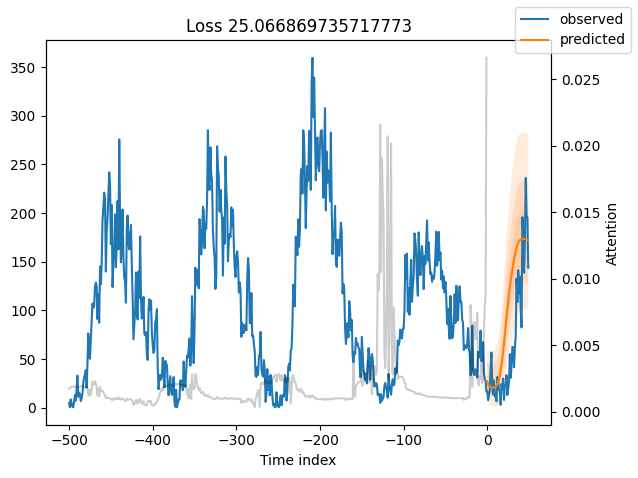

In [12]:
for idx in range(raw_predictions.prediction.shape[0]):
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

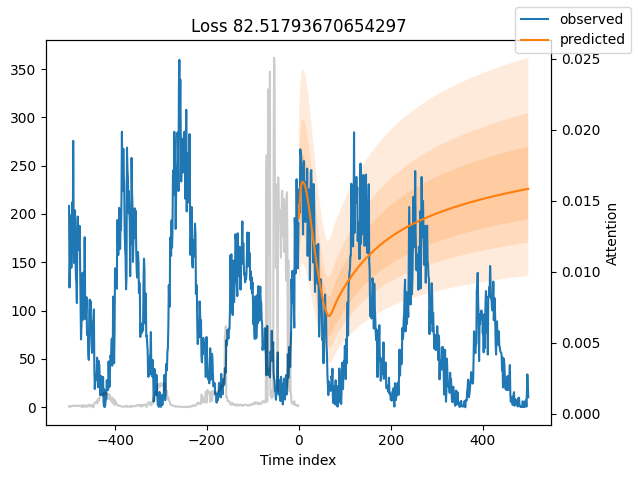

In [13]:
max_prediction_length = 500
max_encoder_length = 500
training_cutoff = df["time_idx"].max() - max_prediction_length - max_encoder_length
test3 = TimeSeriesDataSet(
    df[lambda x: x.time_idx > training_cutoff],
    time_idx = "time_idx",
    target = 'sunspots',
    group_ids = ["const"],
    min_encoder_length = max_encoder_length,
    max_encoder_length = max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["sunspots"],
    target_normalizer=GroupNormalizer(
        groups=["const"], transformation="softplus"
    ), 
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True
)


#raw_predictions = best_tft.predict(test3, mode="prediction")

#print("raw_predictions: ", raw_predictions)
raw_predictions, x = best_tft.predict(test3, mode="raw", return_x=True)

#print(x['decoder_target'].shape)
#print(x['decoder_target'])
#print(x["decoder_time_idx"].shape)
#print(x["decoder_time_idx"])

#print(x)

for idx in range(1):
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

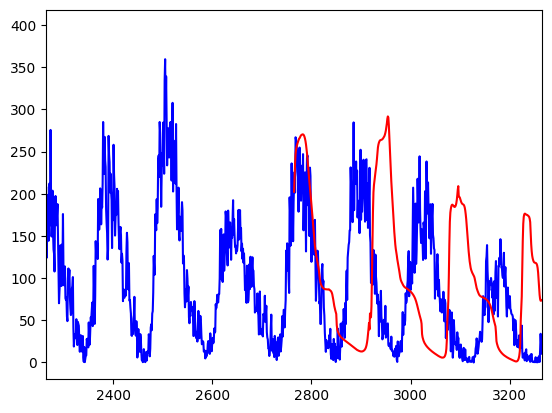

In [14]:
import matplotlib.pyplot as plt

def moving_window(window, window_size, tft):
    dataset = TimeSeriesDataSet(
        window,
        time_idx = "time_idx",
        target = 'sunspots',
        group_ids = ["const"],
        min_encoder_length = window_size,
        max_encoder_length = window_size,
        min_prediction_length=1,
        max_prediction_length=1,
        time_varying_known_reals=["time_idx"],
        time_varying_unknown_reals=["sunspots"],
        target_normalizer=GroupNormalizer(
            groups=["const"], transformation="softplus"
        ), 
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True
    )
    
    return tft.predict(dataset, mode="prediction", return_x=False)[0][0]

def predict_by_moving_window(df, window_size, steps, tft):
    start = df["time_idx"].max() - window_size - steps
    start_window = (df[lambda x: x.time_idx >= start])[lambda x: x.time_idx < start + window_size]
    start_time_idx = start_window["time_idx"].iloc[-1] + 1
    new_element = pd.DataFrame.from_dict({'sunspots': [0], 'time_idx': [start_time_idx],'const': [1]})
    window = pd.concat([start_window, new_element], ignore_index=True)
    res = []
    for i in range(steps):
        result = moving_window(window, window_size, best_tft).item()
        window.at[window_size, "sunspots"] = result
        res.append(result)
        new_element = pd.DataFrame.from_dict({'sunspots': [0], 'time_idx': [start_time_idx+i+1],'const': [1]})
        window = pd.concat([window.tail(-1), new_element], ignore_index=True)
    return res

test_obs = 500
encoder_length = 500
predictions = predict_by_moving_window(df, encoder_length, test_obs, best_tft)
X = df["sunspots"]
    
plt.plot(X, color = 'blue', label = 'Original')
plt.plot(range(len(X)-test_obs, len(X)), predictions, color = 'red',label = 'Rolling Mean')
plt.xlim((len(X)-test_obs-encoder_length, len(X)))
plt.show()